## Validate CA3 projections in CA1 microcircuit

In [15]:
# !pip install --upgrade pandas
# !pip install -q pyarrow
# !pip install -q -i https://bbpteam.epfl.ch/repository/devpi/simple/ voxcell

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from os import path
from datetime import datetime
from voxcell import VoxelData, Hierarchy
from voxcell.nexus.voxelbrain import Atlas

/opt/conda/envs/python2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
projection_base = '/mnt/circuits/O1/20181114/projection/'
path_syns = path.join(projection_base, 'synapses.feather')
# path_pre = path.join(projection_base, 'virtual-fibers.csv')

In [3]:
atlas_path = '/mnt/entities/dev/atlas/O1-243/'
volume_path = path.join(atlas_path, 'brain_regions.nrrd')
hierarchy_path = path.join(atlas_path, 'hierarchy.json')

In [4]:
# pre = pd.read_csv(path_pre)
# pre.head()

In [5]:
# pregid = int(pre['sgid'].values)
pregid = 1000000

In [6]:
syns = pd.read_feather(path_syns)
# pd.read_feather(path_syns)
syns.head()

,offset,x,y,z,section_id,segment_id,tgid,sgid_path_distance,sgid
0,0.619206,866.949678,420.800488,961.502316,158,23,1966,1.813566,0
1,5.004660,821.907294,188.902518,428.473130,109,12,9311,10.821948,0
2,0.102776,541.799133,405.830667,507.966888,160,53,3264,0.723073,0
3,0.307752,207.664854,326.225937,975.833187,156,29,16251,1.282181,0
4,1.115617,380.937872,330.437651,316.913136,131,0,9429,1.681385,0


**Columns**

gid = fiber gid  (it should coincide with presynaptic gid. Reduntant)

Section.ID = section id where the synapse is located in the postsynaptic cell

Segment.ID = segment id where the synapse is located in the postsynaptic cell

segment_length = segment length where the synapse is located in the postsynaptic cell

x,y,z = synapse position

section_id = Section.ID (reduntant)

segment_id = Segment.ID (reduntant)

tgid = postsynaptic (target) gid

sgid_path_distance = path distance of the synapse in presynaptic (source) cell

sgid = presynaptic (source) gid

In [7]:
vd = VoxelData.load_nrrd(volume_path)
hierarchy = Hierarchy.load_json(hierarchy_path)

atlas = Atlas.open(atlas_path)
annotation = atlas.load_data('brain_regions')
rmap = atlas.load_region_map()

### Distribution across layers

In [8]:
id_layer_map = {k: v for v in ['SLM', 'SR', 'SP', 'SO'] for k in rmap.find('@%s' % v, attr='acronym')}

In [9]:
# helper function to map synapse position to layer (SO, SP, SR, SLM)

def map_pos_layer(row):
    point = (row.x, row.y, row.z)
    ID = vd.lookup(point,outer_value=-1)
    if ID not in id_layer_map.keys():
        return 'out'
    return id_layer_map[int(ID)]

In [10]:
syns['layer'] = syns.apply(map_pos_layer, axis=1)
syns.head()

,offset,x,y,z,section_id,segment_id,tgid,sgid_path_distance,sgid,layer
0,0.619206,866.949678,420.800488,961.502316,158,23,1966,1.813566,0,SR
1,5.004660,821.907294,188.902518,428.473130,109,12,9311,10.821948,0,SP
2,0.102776,541.799133,405.830667,507.966888,160,53,3264,0.723073,0,SR
3,0.307752,207.664854,326.225937,975.833187,156,29,16251,1.282181,0,SR
4,1.115617,380.937872,330.437651,316.913136,131,0,9429,1.681385,0,SR


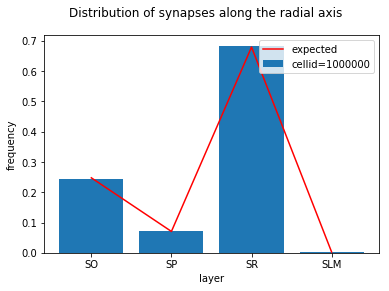

In [11]:
# model distribution
layers = ['SO', 'SP', 'SR', 'SLM']
mod_y_distr = [sum(syns.layer==layer) for layer in layers]
mod_y_distr = np.array(mod_y_distr,dtype='float')
mod_y_distr = mod_y_distr/mod_y_distr.sum()
exp_y_distr = [0.2476014415, 0.0705293209, 0.6792951748, 0.0025740628]
x = np.arange(4)
fig, ax = plt.subplots()
ax.bar(x, mod_y_distr, label='cellid='+str(pregid))
ax.plot(x,exp_y_distr,color='r', label='expected')
plt.xticks(x, layers)
fig.suptitle('Distribution of synapses along the radial axis')
ax.set_xlabel('layer')
ax.set_ylabel('frequency')
plt.legend(loc='upper right')
timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')
# plt.savefig('/home/romani/Desktop/radial_distr_'+timestamp+'.png')
plt.show()

### Distribution over XZ plane

Verify that the synapses are distributed uniformly in the XZ plane

In [ ]:
!pip install -q feather-format

[]

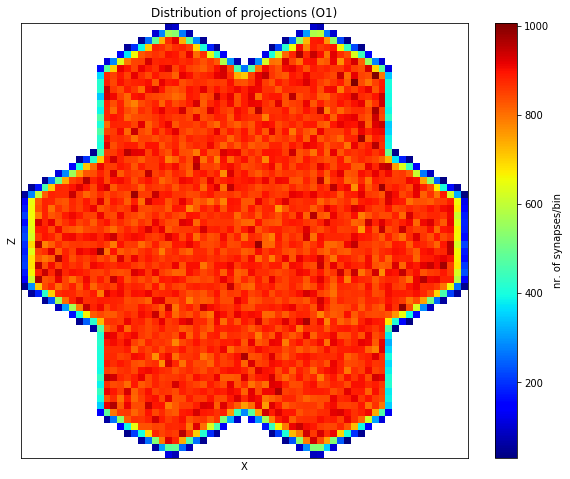

In [12]:
# read in synapse xyzs
import feather
# proj_path = "/gpfs/bbp.cscs.ch/project/proj42/circuits/O1/20181114/projection/synapses.feather"
syns = feather.read_dataframe(path_syns)  # workaround to read from feather format...
xyz = syns[["x", "y", "z"]]

# convert to density matrix
import numpy as np
def bin_space(x, y, x_min, x_max, y_min, y_max, bin_size):
    """"Bins the space for 'density plot'"""

    x_bins = np.arange(x_min, x_max, bin_size)
    y_bins = np.arange(y_min, y_max, bin_size)
    x_bins = np.append(x_bins, x_max); y_bins = np.append(y_bins, y_max)
    X = np.zeros((len(x_bins)-1, len(y_bins)-1))

    for i, (x_from, x_to) in enumerate(zip(x_bins[0:-1], x_bins[1:])):
        idx_x = np.where((x_from < x) & (x <= x_to))[0]
        for j, (y_from, y_to) in enumerate(zip(y_bins[0:-1], y_bins[1:])):
            idx_y = np.where((y_from < y[idx_x]) & (y[idx_x] <= y_to))[0]
            X[i, j] = len(idx_y)

    X[np.where(X == 0)] = np.nan

    return X
x_min = -260.0; x_max = 980.0
z_min = -20.0; z_max = 1280.0
bin_size = 20
dens_O1 = bin_space(xyz["x"].values, xyz["z"].values, x_min, x_max, z_min, z_max, bin_size)

# plt
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
i = ax.imshow(dens_O1, cmap="jet", aspect="auto", interpolation="nearest", origin="lower")
fig.colorbar(i, label="nr. of synapses/bin")
ax.set_title("Distribution of projections (O1)")
ax.set_xlabel("X"); ax.set_ylabel("Z")
ax.set_xticks([]); ax.set_yticks([])